# __Classifieur de sites web malveillants__
## __Introduction__

Les services informatiques déstinées à l'usage publique sont généralement exploitable à travers des sites web. 

De ce fait, les utilisateurs se trouvent souvent dans des sites web malveillants qui ont pour but dans le plus fréquent des cas de collecter des données utilisateurs.

De nos jours, la cybersécurité et l'infosec fait appel à des techniques du ML pour augmenter la sécurité, et dans ce qui suit j'expliquerai comment implémenter un classifieur de sites web selon la malveillance.

## __Approche générale__
> *Remarque : le dataset utilisé se trouve [ici](https://drive.google.com/file/d/16ZoWefXlM386ZaxDtPkotzHVBE169oOh/view?usp=sharing)*

Dans un premier temps on se pose les questions suivantes :

- Est-ce que la localisation géographique du site web (pays) permet de donner d'information sur sa malveillance ? 
- Comment les données dont corrélées entre-elles ?
- Quel est l'élément principal dans la description du comportement global d'un site web ?

## __Analyser les données__
C'est la partie la plus importante dans tout le processus d'implémentation qui nous permettera de savoir si les données sont structurées, semi-structurées ou non-structurées, y a t'il des valeurs manquantes, y a t'il un bruit (noisy data) ou pas.

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
df.shape

(1781, 21)

In [ ]:
df.head(10)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0
5,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,11,6,9,894,11,13,838,894,11,0.0,0
6,B0_462,18,6,iso-8859-1,Apache/2,345.0,US,CO,29/07/2002 0:00,1/07/2016 0:00,12,0,3,1189,14,13,8559,1327,14,2.0,0
7,B0_1128,19,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,FL,18/03/1997 0:00,19/03/2017 0:00,0,0,0,0,0,0,0,0,0,0.0,0
8,M2_17,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,3,213,146,2,2.0,1
9,M3_75,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,1,62,146,2,2.0,1


In [ ]:
df.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

## __Préparation des données__
En comprenant le sense des données, on s'apperçoit clairement qu'il y a du bruit.

Par exemple, la colonne CHARSET a des valeurs en majiscule mais d'autres en miniscule, donc déjà faut convertir le tout en majiscule.

De meme, la colonne WHOIS_COUNTRY a le meme problème, et il y a aussi des valeurs manquantes d'où la nécéssité d'une interpolation.

In [ ]:
df[pd.isnull(df).any(axis=1)]

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
5,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,11,6,9,894,11,13,838,894,11,0.0,0
8,M2_17,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,3,213,146,2,2.0,1
9,M3_75,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,1,62,146,2,2.0,1
10,B0_1013,20,6,utf-8,Apache,NaN,US,Kansas,14/09/2007 0:00,9/09/2015 0:00,0,0,0,0,0,0,0,0,0,0.0,0
20,B0_161,22,6,utf-8,openresty/1.11.2.1,NaN,US,CA,3/07/1999 0:00,7/08/2015 0:00,39,29,6,3833,43,42,22495,4125,43,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,M4_39,178,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0,1
1775,M4_45,194,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0,1
1776,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0,1
1777,M4_41,198,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,2,124,0,0,0.0,1


In [ ]:
df=df.interpolate()
print(df.isnull().sum())

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       1
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64


In [ ]:
df['CHARSET'].unique() 
df['CHARSET']=np.where(df['CHARSET'] =='iso-8859-1', 'ISO-8859-1', df['CHARSET'])
df['CHARSET']=np.where(df['CHARSET'] =='utf-8', 'UTF-8', df['CHARSET'])

In [ ]:
def replace_values(x):
  df[x]=np.where(df['WHOIS_COUNTRY'] =='United Kingdom', 'UK', df['WHOIS_COUNTRY'])
  df[x]=np.where(df['WHOIS_COUNTRY'] =="[u'GB'; u'UK']", 'UK', df['WHOIS_COUNTRY'])
  df[x]=np.where(df['WHOIS_COUNTRY'] =='United Kingdom', 'UK', df['WHOIS_COUNTRY'])
  df[x]=np.where(df['WHOIS_COUNTRY'] =='us', 'US', df['WHOIS_COUNTRY'])
  df[x]=np.where(df['WHOIS_COUNTRY'] =='se', 'SE', df['WHOIS_COUNTRY'])
  df[x]=np.where(df['WHOIS_COUNTRY'] =='ru', 'RU', df['WHOIS_COUNTRY'])
replace_values("WHOIS_COUNTRY")

In [ ]:
df.describe(include='all')

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781,1781.000000,1781.000000,1781,1780,1781.000000,1781,1781,1781,1781,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1781.000000,1781.000000
unique,1781,NaN,NaN,7,239,NaN,44,182,891,594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B0_291,NaN,NaN,UTF-8,Apache,NaN,US,CA,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,1055,386,NaN,1106,372,127,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,56.961258,11.111735,NaN,NaN,13497.243964,NaN,NaN,NaN,NaN,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263335,0.121280
std,NaN,27.555586,4.549896,NaN,NaN,38415.552697,NaN,NaN,NaN,NaN,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930036,0.326544
min,NaN,16.000000,5.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,NaN,39.000000,8.000000,NaN,NaN,603.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,NaN,49.000000,10.000000,NaN,NaN,4714.750000,NaN,NaN,NaN,NaN,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,NaN,68.000000,13.000000,NaN,NaN,12578.500000,NaN,NaN,NaN,NaN,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000


In [ ]:
df['Type'].value_counts()

0    1565
1     216
Name: Type, dtype: int64

Ensuite, on peut répondre à la question clé de cette analyse :
> Quelles sont les colonnes (variables) qui sont les plus représentatives et influentes ? 

Une façon de répondre à celà consiste à calculer la matrice de corrélation.


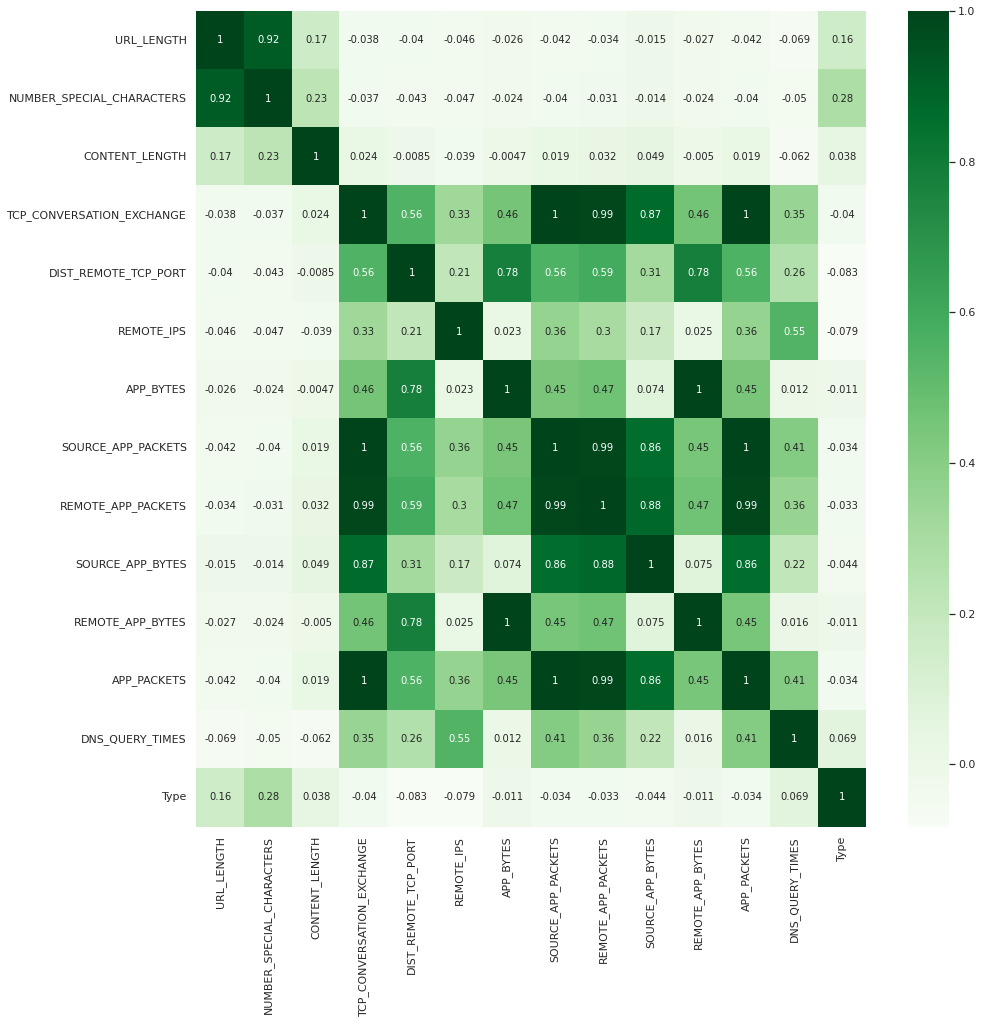

In [ ]:
correlation = df.corr()
plt.figure(figsize = (15, 15))
sns.set(font_scale = 1)
sns.heatmap(correlation, annot = True, annot_kws = {'size': 10}, cmap = 'Greens')

> Constat : les colonnes URL_LENGTH, NUMBER_SPECIAL_CHARACTERS, DNS_QUERY_TIMES ont la plus grande corrélation avec la colonne TYPE.

> Conclusion : l'entrainement doit se faire sur ces propriétés, car c'est les paramètres les plus influents sur le type du site web.

## __Modélisation et résultats__
J'ai utilisé deux approches différentes pour la classification :
> - Random forest 
> - K-Nearest Neighbors avec k = 4

Text(0, 0.5, "Taux d'erreur")

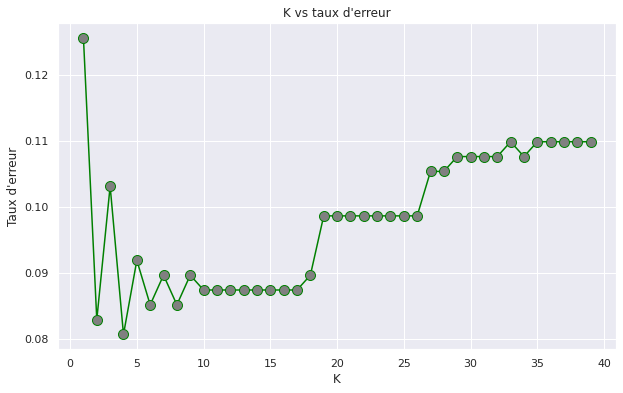

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report

error_rate = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    
    error_rate.append(np.mean(pred_i != y_test))
    
   
plt.figure(figsize=(10, 6))

plt.plot(range(1, 40), error_rate, color='green', linestyle='-',
         markersize=10, markerfacecolor='grey', marker='o')
plt.title('K vs taux d\'erreur')
plt.xlabel('K')
plt.ylabel('Taux d\'erreur')

In [ ]:
k = 4
clf = KNeighborsClassifier(n_neighbors=k, p=3, weights='distance',leaf_size=50)
clf.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=50, n_neighbors=4, p=3, weights='distance')

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print("Précision %d NN: %.2f %%" % (k, 100 * accuracy_score(y_test.to_numpy(), y_pred)))
from sklearn.metrics import roc_auc_score
roc_value = roc_auc_score(y_test, y_pred)
print(roc_value)

Accuracy of 4 NN: 90.13 %
0.7008478643417052


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

print("Précision Random forest: %.2f %%" % ( 100 * accuracy_score(y_test.to_numpy(), y_pred)))
from sklearn.metrics import roc_auc_score
roc_value = roc_auc_score(y_test, y_pred)
print(roc_value)

Accuracy of Random forest: 95.29 %
0.7953660747613714


In [ ]:
print('Classification Report:\n{}\n'.format(classification_report(y_test.to_numpy(),y_pred)))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       399
           1       0.93      0.60      0.73        47

    accuracy                           0.95       446
   macro avg       0.94      0.80      0.85       446
weighted avg       0.95      0.95      0.95       446




J'ai eu une meilleure précision avec la première méthode, ceci peut etre expliqué comme suit : 

> KNN (k=4) : précision = 90.13 % 
> RF : précision = 95.29 %

- Cet algorithme peut prendre en charge des données dans un espace de dimension large
- Un bon estimateur pour les valeurs manquantes